In [1]:
!mkdir data
%cd data

!gdown 1uYXI4O3oWBA6QC8ZJ-r6yaTTfkdAnl_Q

%cd ..

d:\AIVietNam\2024\aio-2024-hw\module-6\14_12_2024_M06W03\data


A subdirectory or file data already exists.


d:\AIVietNam\2024\aio-2024-hw\module-6\14_12_2024_M06W03


Downloading...
From: https://drive.google.com/uc?id=1uYXI4O3oWBA6QC8ZJ-r6yaTTfkdAnl_Q
To: d:\AIVietNam\2024\aio-2024-hw\module-6\14_12_2024_M06W03\data\dataset.zip

  0%|          | 0.00/230k [00:00<?, ?B/s]
100%|██████████| 230k/230k [00:00<00:00, 1.35MB/s]
100%|██████████| 230k/230k [00:00<00:00, 1.34MB/s]


In [2]:
import zipfile

with zipfile.ZipFile('./data/dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('./data')

In [3]:
import torch
import torch.nn as nn

seed = 1
torch.manual_seed(seed)

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
import unidecode

nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
headers = ['sentiment', 'content']
df = pd.read_csv(
    './data/dataset/all-data.csv',
    names=headers,
    encoding='ISO-8859-1'
)
df.head()

,sentiment,content
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [5]:
classes = {
    class_name: idx
    for idx, class_name in enumerate(df['sentiment'].unique())
}
classes

{'neutral': 0, 'negative': 1, 'positive': 2}

In [6]:
df['sentiment'] = df['sentiment'].apply(lambda x: classes[x])
df.head()

,sentiment,content
0,0,"According to Gran , the company has no plans t..."
1,0,Technopolis plans to develop in stages an area...
2,1,The international electronic industry company ...
3,2,With the new production plant the company woul...
4,2,According to the company 's updated strategy f...


In [7]:
english_stop_words = stopwords.words('english')
stemmer = PorterStemmer()

def text_normalizer(text):
    text = text.lower()
    text = unidecode.unidecode(text)
    text = text.strip()
    text = re.sub(r'[^\w\s]', '', text)
    text = ' '.join([word for word in text.split(' ') if word not in english_stop_words])
    text = ' '.join([stemmer.stem(word) for word in text.split(' ')])
    return text

In [8]:
df['content'] = df['content'].apply(lambda x: text_normalizer(x))
df.head()

,sentiment,content
0,0,accord gran compani plan move product russia ...
1,0,technopoli plan develop stage area less 100000...
2,1,intern electron industri compani elcoteq laid ...
3,2,new product plant compani would increas capac ...
4,2,accord compani updat strategi year 20092012 b...


In [11]:
vocab = set()
for sentence in df['content'].tolist():
    tokens = sentence.split()
    for token in tokens:
        vocab.add(token)

vocab = list(vocab)
vocab.append('UNK')
vocab.append('PAD')
word_to_idx = {word: idx for idx, word in enumerate(vocab)}
vocab_size = len(vocab)
vocab

['annul',
 'hkse',
 '107',
 'ing',
 '19447574',
 'atvi',
 'deliveri',
 'pattern',
 'rushydro',
 'lanebrook',
 '67mn',
 'liora',
 '373',
 'hydrogen',
 'lat',
 'intellectu',
 'purchas',
 '509',
 'tm',
 'snowfal',
 '1058',
 'seamless',
 '13300',
 'buster',
 'delhaiz',
 'extern',
 'sysopen',
 'tommi',
 'scotland',
 'caverion',
 'israel',
 '25349',
 'quantiti',
 'lc',
 'tellab',
 'unrival',
 'shrank',
 'sixstep',
 'weigh',
 'worth',
 'bidirection',
 '401',
 'conserv',
 'desarrollo',
 'friendli',
 'ead',
 'bestsel',
 'mill',
 'napoli',
 '385000',
 '4572',
 'want',
 'sepa',
 'app',
 'cowi',
 'follum',
 'viitaniemi',
 'attract',
 'administr',
 'bukoba',
 'entertain',
 'jarvinen',
 '70',
 'kilogram',
 'bratislava',
 'hienonen',
 'turku',
 'mayb',
 'one',
 'outstand',
 'soar',
 'geographi',
 'friend',
 'resili',
 'igen3',
 'oil',
 'protect',
 'diagrid',
 'cant',
 'alleg',
 '300mn',
 'jarvenpaa',
 'settlement',
 'magnetit',
 'prosper',
 'hit',
 '2bn',
 'hanninen',
 '258',
 'ghz',
 'vitim',
 'mose

In [12]:
def transform(text, word_to_idx, max_seq_len):
    tokens = []
    for w in text.split():
        try:
            w_ids = word_to_idx[w]
        except:
            w_ids = word_to_idx['UNK']
        tokens.append(w_ids)
    
    if len(tokens) < max_seq_len:
        tokens += [word_to_idx['PAD']] * (max_seq_len - len(tokens))
    elif len(tokens) > max_seq_len:
        tokens = tokens[:max_seq_len]
    return tokens

In [13]:
val_size = 0.2
test_size = 0.125
is_shuffle = True
texts = df['content'].tolist()
labels = df['sentiment'].tolist()

X_train, X_val, y_train, y_val = train_test_split(
    texts, labels,
    test_size=val_size,
    random_state=seed,
    shuffle=is_shuffle
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train,
    test_size=test_size,
    random_state=seed,
    shuffle=is_shuffle
)

In [14]:
class FinancialNews(Dataset):
    def __init__(self, X, y, word_to_idx, max_seq_len, transform=None):
        super().__init__()
        self.texts = X
        self.labels = y
        self.word_to_idx = word_to_idx
        self.max_seq_len = max_seq_len
        self.transform = transform
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        
        if self.transform:
            text = self.transform(
                text,
                self.word_to_idx,
                self.max_seq_len
            )
        
        text = torch.tensor(text)
        return text, label

In [15]:
max_seq_len = 32

train_ds = FinancialNews(
    X_train, y_train,
    word_to_idx=word_to_idx,
    max_seq_len=max_seq_len,
    transform=transform
)
val_ds = FinancialNews(
    X_val, y_val,
    word_to_idx=word_to_idx,
    max_seq_len=max_seq_len,
    transform=transform
)
test_ds = FinancialNews(
    X_test, y_test,
    word_to_idx=word_to_idx,
    max_seq_len=max_seq_len,
    transform=transform
)
train_batch_size = 128
test_batch_size = 8

train_loader = DataLoader(
    train_ds,
    batch_size=train_batch_size,
    shuffle=True
)
val_loader = DataLoader(
    val_ds,
    batch_size=test_batch_size,
    shuffle=False
)
test_loader = DataLoader(
    test_ds,
    batch_size=test_batch_size,
    shuffle=False
)

In [16]:
class SentimentalClassifier(nn.Module):
    def __init__(
        self, vocab_size, embedding_dim,
        hidden_size, n_layers, n_classes,
        dropout_prob
    ):
        super(SentimentalClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # batch_first: If True, then the input and output tensors are provided
        self.rnn = nn.RNN(embedding_dim, hidden_size, n_layers, batch_first=True)
        self.norm = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc1 = nn.Linear(hidden_size, 16)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(16, n_classes)
        
    def forward(self, x):
        x = self.embedding(x)
        x, hn = self.rnn(x)
        x = x[:, -1, :]
        x = self.norm(x)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        
        return x

In [17]:
n_classes = len(classes)
embedding_dim = 64
hidden_size = 64
n_layers = 2
dropout_prob = 0.2
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = SentimentalClassifier(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    hidden_size=hidden_size,
    n_layers=n_layers,
    n_classes=n_classes,
    dropout_prob=dropout_prob
).to(device)

In [18]:
lr = 1e-4
epochs = 50

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=lr
)

In [19]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    losses = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            losses.append(loss.item())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    loss = sum(losses) / len(losses)
    acc = correct / total
    
    return loss, acc

In [20]:
def fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    epochs
):
    train_losses = []
    val_losses = []

    for epoch in range ( epochs ) :
        batch_train_losses = []
        model.train()
        
        for idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            batch_train_losses.append(loss.item())
            
        train_losses.append(sum(batch_train_losses) / len(batch_train_losses))
        val_loss, val_acc = evaluate(
            model, val_loader,
            criterion, device
        )
        val_losses.append(val_loss)
        print (f'EPOCH {epoch + 1}:\tTrain loss: {train_losses[-1]:.4f}\tVal loss : {val_losses[-1]:.4f}')
        
    return train_losses, val_losses

In [21]:
train_losses, val_losses = fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    epochs
)

EPOCH 1:	Train loss: 1.0104	Val loss : 0.9532
EPOCH 2:	Train loss: 0.9442	Val loss : 0.9332
EPOCH 3:	Train loss: 0.9338	Val loss : 0.9289
EPOCH 4:	Train loss: 0.9321	Val loss : 0.9280
EPOCH 5:	Train loss: 0.9311	Val loss : 0.9278
EPOCH 6:	Train loss: 0.9291	Val loss : 0.9281
EPOCH 7:	Train loss: 0.9284	Val loss : 0.9281
EPOCH 8:	Train loss: 0.9301	Val loss : 0.9281
EPOCH 9:	Train loss: 0.9312	Val loss : 0.9280
EPOCH 10:	Train loss: 0.9295	Val loss : 0.9281
EPOCH 11:	Train loss: 0.9303	Val loss : 0.9282
EPOCH 12:	Train loss: 0.9302	Val loss : 0.9284
EPOCH 13:	Train loss: 0.9281	Val loss : 0.9282
EPOCH 14:	Train loss: 0.9290	Val loss : 0.9281
EPOCH 15:	Train loss: 0.9260	Val loss : 0.9280
EPOCH 16:	Train loss: 0.9283	Val loss : 0.9279
EPOCH 17:	Train loss: 0.9272	Val loss : 0.9280
EPOCH 18:	Train loss: 0.9318	Val loss : 0.9280
EPOCH 19:	Train loss: 0.9266	Val loss : 0.9279
EPOCH 20:	Train loss: 0.9276	Val loss : 0.9278
EPOCH 21:	Train loss: 0.9268	Val loss : 0.9276
EPOCH 22:	Train loss: 

Text(0.5, 1.0, 'Validation Loss')

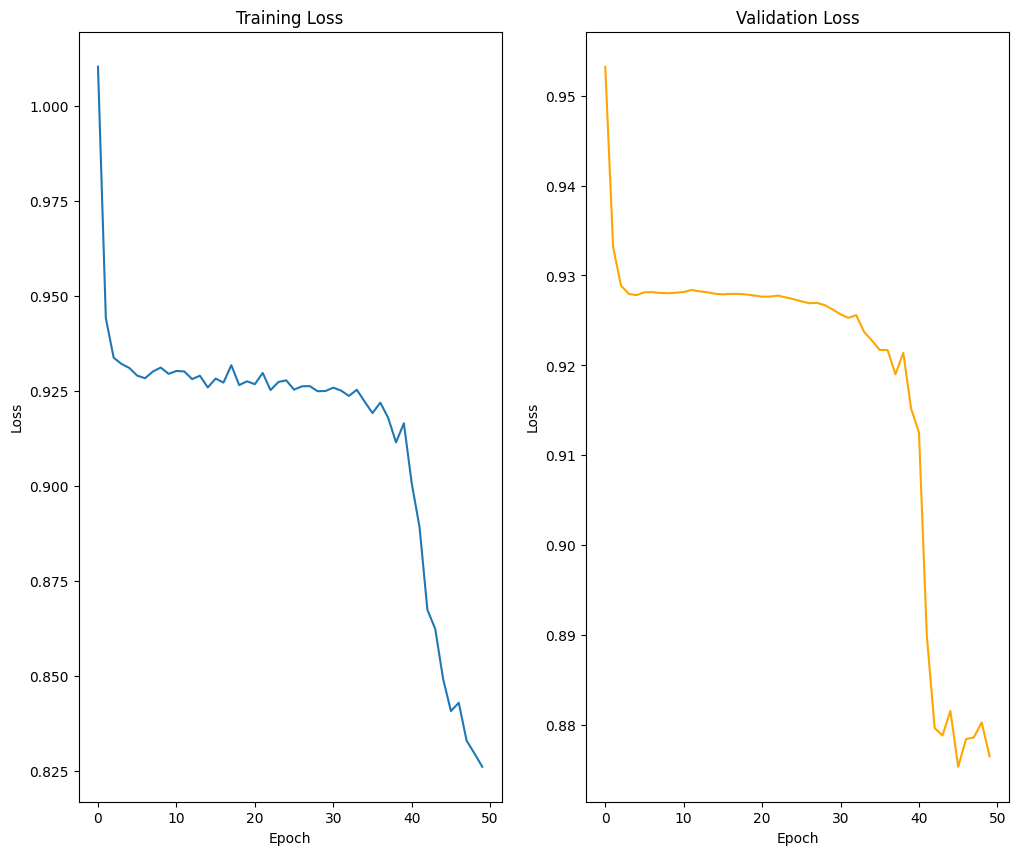

In [26]:
fix, ax = plt.subplots(1, 2, figsize=(12, 10))
ax[0].plot(train_losses)
ax[0].set(xlabel='Epoch', ylabel='Loss')
ax[0].set_title('Training Loss')

ax[1].plot(val_losses, color='orange')
ax[1].set(xlabel='Epoch', ylabel='Loss')
ax[1].set_title('Validation Loss')

In [27]:
val_loss, val_acc = evaluate(
    model,
    val_loader,
    criterion,
    device
)
test_loss, test_acc = evaluate(
    model,
    test_loader,
    criterion,
    device
)

print('Evaluation on val / test dataset ')
print(f'Val accuracy: {val_acc}' )
print(f'Test accuracy: {test_acc}' )

Evaluation on val / test dataset 
Val accuracy: 0.6195876288659794
Test accuracy: 0.6474226804123712
